# File info

In [6]:
#------------#
#-- author --#
#------------#
# Jason Schatz
# Created:  04.04.2017

#-----------------#
#-- Description --#
#-----------------#
# describes relationships between land surface characteristics & 
# air temperature at 138 weather stations in and around Madison, 
# Wisconsin using various machine learning models, including:
#   -ordinary least squares
#   -robust regression
#   -random forest
#   -gradient boosted regression tree
#   -SVN

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

C:\Users\jason.schatz\AppData\Local\Continuum\Anaconda2-4\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\jason.schatz\AppData\Local\Continuum\Anaconda2-4\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Define functions

In [3]:
def draw_histograms(df, variables):
    '''plots matrix of histograms
    
    Args:
        df: pandas df of variables
        variables: list of variables to plot

    Returns:
        histograms of listed variables
    '''
    n_rows = int(round(len(variables)**0.5 + 0.5))
    n_cols = int(round(len(variables) / float(n_rows)) + 0.5)
    fig = plt.figure()
    for idx, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, idx + 1)
        df[var_name].hist(bins=10, ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

def plot_corr(df, size=10):
    '''plots a graphical correlation matrix for each pair of columns in a dataframe.

    Input:
        df: pandas df
        size: vertical and horizontal size of the plot
    '''
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.show()

# Prep data for analysis

In [151]:
## read data
data = pd.read_csv('C:/Users/jason.schatz/Desktop/ML_temperature/temperature_data.csv')
covariates = pd.read_csv('C:/Users/jason.schatz/Desktop/ML_temperature/station_covariates.csv')
df = pd.merge(data, covariates, how='left', on=['SID'])

## drop na rows
df.isnull().sum()
df.dropna(inplace=True)

## define variables of interest
predictors = ['Lake.distance', 'Imp500', 'ELEV']
response = 'tmin'

X = df[predictors].values
y = df[response].values

## traing/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## scale features (where necessary)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Data exploration

histograms

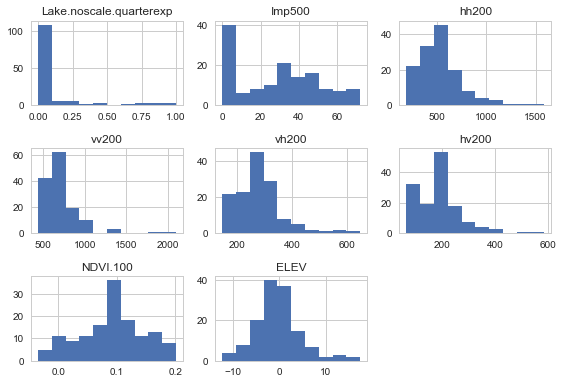

In [45]:
draw_histograms(df, predictors)

correlation matrix

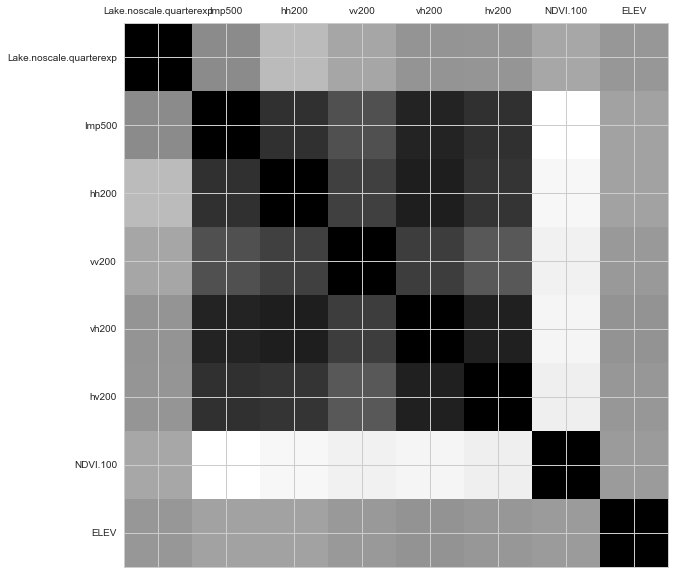

In [46]:
plot_corr(df[predictors], size=10)

scatterplot matrix

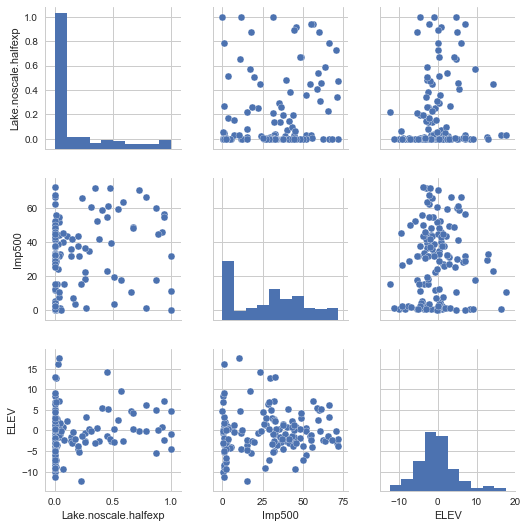

In [26]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df[predictors], size=2.5)
plt.tight_layout()
plt.show()

# ordinary least squares

In [174]:
from sklearn.linear_model import LinearRegression

## data prep
predictors = ['Lake.noscale.halfexp', 'Imp500', 'ELEV']
X = df[predictors].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## train OLS model
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

#print('Slope: %.3f' % slr.coef_[0])
#print('Intercept: %.3f' % slr.intercept_)

print('Training MSE: %.2f' % mean_squared_error(y_train, y_train_pred),
      'Test MSE: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Training R2: %.2f' % r2_score(y_train, y_train_pred),
      'Test R2: %.2f' % r2_score(y_test, y_test_pred))

## plot relationship of single trait
#def lin_regplot(X, y, model):
#    plt.scatter(X, y, c='lightblue')
#    plt.plot(X, model.predict(X), color='red', linewidth=2)    
#    return 

#lin_regplot(X_test, y_test_sqrt, slr)
#plt.xlabel('vv backscatter from sentinel 1')
#plt.ylabel('tmin')
#plt.tight_layout()
#plt.show()

('Training MSE: 0.14', 'Test MSE: 0.21')
('Training R2: 0.83', 'Test R2: 0.82')


# robust linear regression

In [27]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                         residual_threshold=5.0, 
                         random_state=0)
ransac.fit(X_train, y_train)
y_train_pred = ransac.predict(X_train)
y_test_pred = ransac.predict(X_test)
#print ransac.estimator_.coef_[0]   #slope
#print ransac.estimator_.intercept_   #intercept

print('Training MSE: %.2f' % mean_squared_error(y_train, y_train_pred),
      'Test MSE: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Training R2: %.2f' % r2_score(y_train, y_train_pred),
      'Test R2: %.2f' % r2_score(y_test, y_test_pred))

('Training MSE: 0.16', 'Test MSE: 0.15')
('Training R2: 0.81', 'Test R2: 0.86')


C:\Users\jason.schatz\AppData\Local\Continuum\Anaconda2-4\lib\site-packages\sklearn\linear_model\ransac.py:261: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


In [28]:
## plot ransac inliers, outliers (for single predictors)
def plot_ransac(model, x_data, y_data, xlab, ylab):
    inlier_mask = model.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(3, 10, 1)
    line_y_ransac = ransac.predict(line_X[:, np.newaxis])

    plt.scatter(x_data[inlier_mask], y_data[inlier_mask], c='blue', marker='o', label='Inliers')
    plt.scatter(x_data[outlier_mask], y_data[outlier_mask], c='lightgreen', marker='s', label='Outliers')
    plt.plot(line_X, line_y_ransac, color='red')   
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

#plot_ransac(model=ransac, 
#            x_data=X_train, 
#            y_data=y_train, 
#            xlab='vv backscatter', 
#            ylab='tmin')

# Random forest regression

In [7]:
## grid search to tune hyperparameters
param_grid = [{'criterion': ['mse'],
               'n_estimators': [1000, 3000, 5000],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1]}]
rf1 = RandomForestRegressor()
grid = GridSearchCV(estimator=rf1,
                    param_grid=param_grid,
                    cv=10,
                    n_jobs=-1)
gs = grid.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.703948567286
{'max_features': 'sqrt', 'n_estimators': 1000, 'criterion': 'mse', 'min_samples_leaf': 1}


In [93]:
predictors = ['Lake.noscale.halfexp', 'Imp500', 'ELEV']
X = df[predictors].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## fit random forest model
rf = RandomForestRegressor(criterion='mse',
                           n_estimators=1000,
                           min_samples_split=10,
                           n_jobs=-1, 
                           oob_score=True)
rf.fit(X_train, y_train)

## accuracy of training and test set predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('Training MSE: %.2f' % mean_squared_error(y_train, y_train_pred),
      'Test MSE: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Training R2: %.2f' % r2_score(y_train, y_train_pred),
      'Test R2: %.2f' % r2_score(y_test, y_test_pred))

('Training MSE: 0.09', 'Test MSE: 0.17')
('Training R2: 0.91', 'Test R2: 0.80')


# gradient boosted regression tree

In [58]:
## grid search to tune hyperparameters
param_grid = [{'n_estimators': [500, 1000, 1500, 2000], 
               'max_depth': [1, 2, 3, 4], 
               'min_samples_split': [2, 3, 4],
               'learning_rate': [0.0001, 0.001, 0.01, 0.1],
               'loss': ['ls']}]
gbm1 = GradientBoostingRegressor()
grid = GridSearchCV(estimator=gbm1,
                    param_grid=param_grid,
                    cv=10,
                    n_jobs=-1)
gs = grid.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.676104421406
{'min_samples_split': 4, 'loss': 'ls', 'learning_rate': 0.001, 'n_estimators': 2000, 'max_depth': 3}


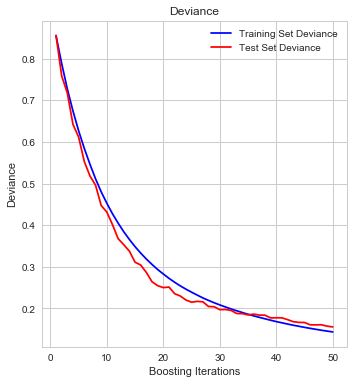

('Training MSE: 0.14', 'Test MSE: 0.16')
('Training R2: 0.85', 'Test R2: 0.81')


In [109]:
predictors = ['Lake.distance', 'Imp500', 'ELEV']
X = df[predictors].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## fit tuned model
params = {'n_estimators': 50, 'max_depth': 1, 'min_samples_split': 4,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)
clf = clf.fit(X_train, y_train)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

## accuracy
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('Training MSE: %.2f' % mean_squared_error(y_train, y_train_pred),
      'Test MSE: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Training R2: %.2f' % r2_score(y_train, y_train_pred),
      'Test R2: %.2f' % r2_score(y_test, y_test_pred))

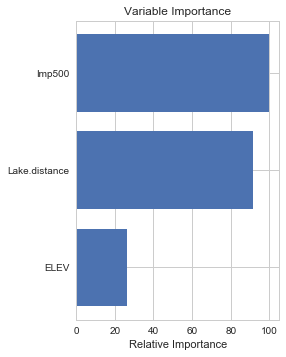

In [110]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
labs = [predictors[i] for i in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, labs)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

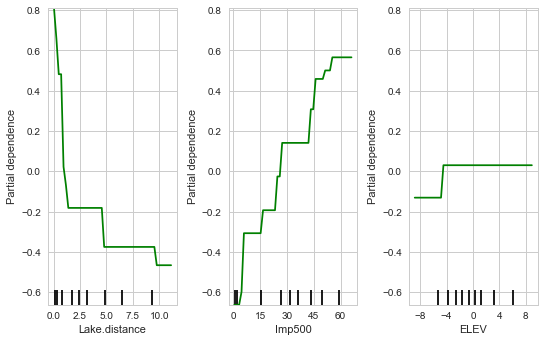

In [111]:
features = [0,1,2]
fig, axs = plot_partial_dependence(clf, X_train, features,
                                   feature_names=predictors,
                                   n_jobs=3, grid_resolution=50)
plt.subplots_adjust(top=0.9) 
plt.show()

# SVM regression

In [152]:
from sklearn.svm import SVR
import itertools

## SVM fits
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1)   # radial basis
#svr_lin = SVR(kernel='linear', C=1e3)           # linear
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)  # polynomial fit
y_rbf = svr_rbf.fit(X_train_std, y_train)
#y_lin = svr_lin.fit(X_train_std, y_train)
#y_poly = svr_poly.fit(X_train_std, y_train)

## accuracy
y_rbf_train_pred = y_rbf.predict(X_train_std)
y_rbf_test_pred = y_rbf.predict(X_test_std)

print('Training MSE: %.2f' % mean_squared_error(y_train, y_rbf_train_pred),
      'Test MSE: %.2f' % mean_squared_error(y_test, y_rbf_test_pred))
print('Training R2: %.2f' % r2_score(y_train, y_rbf_train_pred),
      'Test R2: %.2f' % r2_score(y_test, y_rbf_test_pred))


('Training MSE: 0.15', 'Test MSE: 0.11')
('Training R2: 0.83', 'Test R2: 0.88')
